In [1]:
# append path to find utils module in urbansim
import os 
import sys
cwd = os.getcwd() 
parentdir =  os.path.abspath(os.path.join(cwd, os.pardir))
sys.path.append(parentdir) # to get path to utils module

In [2]:
import pandas as pd
import os, datetime
import numpy as np
import utils
import orca
import matplotlib.pyplot as plt
from pandas.plotting import table
import matplotlib.patches as mpatches
from sqlalchemy import create_engine
from database import get_connection_string
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Rectangle
%matplotlib inline

In [3]:
db_connection_string = get_connection_string('..\data\config.yml', 'mssql_db')
mssql_engine = create_engine(db_connection_string)
versions = utils.yaml_to_dict('../data/scenario_config.yaml', 'scenario')

## Get subregional simulation output

In [4]:
# get max run id from urbansim
run_id_sql = '''
SELECT max(run_id)
  FROM [urbansim].[urbansim].[urbansim_lite_output]
'''
run_id_df = pd.read_sql(run_id_sql, mssql_engine)
run_id = int(run_id_df.values)

print("\n   Max run id : {:,}".format(run_id))


   Max run id : 295


# Specify run_id?

In [5]:
# specify run id
# run_id = 232
# run_id = 109
# print("\n  run id specified : {:,}".format(run_id))

### Simulation output

In [6]:
hs_change_sql = '''SELECT o.parcel_id,  
    unit_change as hs_change, source, capacity_type, year_simulation
      FROM urbansim.urbansim.urbansim_lite_output o 
     WHERE run_id = %s
  ORDER BY  year_simulation'''
hs_change_sql = hs_change_sql % run_id
hs = pd.read_sql(hs_change_sql,mssql_engine)
print("\n   Units added: {:,}".format(int(hs.hs_change.sum())))


   Units added: 435,458


### Geography

In [7]:
geo_sql = '''
SELECT  [parcel_id]
        ,[jur_id] as jurisdiction_id
        ,mgra
        ,name
      ,[cpa_id] 
  FROM [isam].[xpef04].[parcel2015_mgra_jur_cpa] c
  JOIN urbansim.[ref].[jurisdiction] j on j.jurisdiction_id = c.jur_id
  where i = 1'''
geo = pd.read_sql(geo_sql,mssql_engine)

##### simulation output w geography

In [8]:
hs_geo = pd.merge(hs,geo,left_on='parcel_id',right_on='parcel_id',how='left')

##### replace sgoa subtypes with 'sgoa'

In [9]:
hs_geo.replace('cc', 'sgoa',inplace=True)
hs_geo.replace('mc', 'sgoa',inplace=True)
hs_geo.replace('tc', 'sgoa',inplace=True)
hs_geo.replace('tco', 'sgoa',inplace=True)
hs_geo.replace('uc', 'sgoa',inplace=True)

In [10]:
hs_geo.head()

,parcel_id,hs_change,source,capacity_type,year_simulation,jurisdiction_id,mgra,name,cpa_id
0,329171,3,1,sch,2017,1.0,14090.0,Carlsbad,0.0
1,684248,2,1,sch,2017,1.0,14090.0,Carlsbad,0.0
2,5054670,11,1,sch,2017,1.0,14090.0,Carlsbad,0.0
3,5312514,1,1,sch,2017,1.0,14224.0,Carlsbad,0.0
4,5312511,1,1,sch,2017,1.0,14224.0,Carlsbad,0.0


## Get total dwelling units in the region and sum by jurisdiction and cpa

#### note using cap jurisdiction id

In [11]:
du_sql = '''
    SELECT parcel_id, du_2015 as du, du_2017, capacity_2
        FROM urbansim.parcel p
        WHERE (du_2017 > 0 or du_2015 > 0)'''
du = pd.read_sql(du_sql,mssql_engine)
du = pd.merge(du,geo,left_on='parcel_id',right_on='parcel_id',how='left')

print("\n   Dwelling Units 2015: {:,}".format(int(du.du.sum())))
print("\n   Dwelling Units 2017: {:,}".format(int(du.du_2017.sum())))


   Dwelling Units 2015: 1,183,543

   Dwelling Units 2017: 1,192,636


#### get unique CPAs

In [12]:
CPAs = geo.loc[geo.cpa_id>0].cpa_id.unique().tolist()
jurs = geo.jurisdiction_id.unique().tolist()
print("Number of jurisdictions: {:,}".format(len(jurs)))
print("Number of cpas: {:,}".format(len(CPAs)))

Number of jurisdictions: 19
Number of cpas: 86


##### set "jcid" to be jurisdiction or cpa id

In [13]:
units = hs_geo.copy()

In [14]:
units['jcid'] = units['jurisdiction_id']
units.loc[units.jurisdiction_id==14,'jcid'] = units['cpa_id']
units.loc[units.jurisdiction_id==19,'jcid'] = units['cpa_id']

##### dwelling units

In [15]:
dus = du.copy()

In [16]:
dus['jcid'] = dus['jurisdiction_id']
dus.loc[dus.jurisdiction_id == 19,'jcid'] = dus['cpa_id']
dus.loc[dus.jurisdiction_id == 14,'jcid'] = dus['cpa_id']

####  complete the dataset: for CPAs with no unit change, add unit change equal to zero

##### simulation output

In [17]:
units.jcid = units.jcid.astype(int)
units.parcel_id = units.parcel_id.astype(int)
units.set_index('jcid',inplace=True) # necessary for adding missing CPAs

In [18]:
jcids = units.index.unique().tolist()

In [19]:
len(jcids)

88

In [20]:
 # necessary for adding missing CPAs
CPAs_no_unit_change = np.setdiff1d(CPAs,jcids).tolist()

In [21]:
#CPAs_no_unit_change

In [22]:
# need jcid as index here
for cpa in CPAs_no_unit_change:
    units.loc[cpa] = np.nan
units.reset_index(inplace=True) # reset index after assigning CPAs
units.fillna(0,inplace=True)
len(units.jcid.unique())

103

set simulation year to '2017' for CPAs that had no housing unit change to complete dataset

In [23]:
# set year to 2017 for 9 CPAs with no data
units.loc[units.year_simulation==0,'year_simulation'] = 2017
units.year_simulation = units.year_simulation.astype(int)
#units.loc[units.jcid.isin(CPAs_no_unit_change)][['parcel_id','jcid','jurisdiction_id','hs_change',\
#                          'year_simulation']]

##### set jurisdiction id and cpa id for cpas with no unit change

In [24]:
units.loc[units.jcid.isin(CPAs_no_unit_change),'jurisdiction_id' ] = 14

In [25]:
units.loc[((units.jcid.isin(CPAs_no_unit_change)) & (units.jcid> 1500)),'jurisdiction_id' ] = 19

In [26]:
units.loc[units.jcid.isin(CPAs_no_unit_change),'cpa_id' ] = \
units.loc[units.jcid.isin(CPAs_no_unit_change)].jcid

In [27]:
# units.loc[units.jcid.isin(CPAs_no_unit_change)]

##### same for dwelling units

In [28]:
dus.jcid = dus.jcid.astype(int)
dus.parcel_id = dus.parcel_id.astype(int)
dus.set_index('jcid',inplace=True) # necessary for adding missing CPAs
jcids = dus.index.unique().tolist()
CPAs_no_unit_change = np.setdiff1d(CPAs,jcids).tolist()
CPAs_no_unit_change

[1407.0, 1463.0, 1485.0, 1488.0, 1491.0]

In [29]:
# need jcid as index here
for cpa in CPAs_no_unit_change:
    dus.loc[cpa] = np.nan
dus.reset_index(inplace=True) # reset index after assigning CPAs
dus.fillna(0,inplace=True)
len(dus.jcid.unique())

103

## Add cpa name

In [30]:
#update to jcid view
cocpa_names_sql = '''
    SELECT zone as cpa_id, name as cocpa
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 20'''
cocpa_names = pd.read_sql(cocpa_names_sql, mssql_engine)
cicpa_names_sql = '''
    SELECT zone as cpa_id, name as cicpa
    FROM data_cafe.ref.geography_zone WHERE geography_type_id = 15'''
cicpa_names = pd.read_sql(cicpa_names_sql, mssql_engine)
#jur_name
jur_name_sql = '''SELECT [jurisdiction_id],[name] as jur_name FROM [urbansim].[ref].[jurisdiction]'''
jur_name = pd.read_sql(jur_name_sql,mssql_engine)

In [31]:
units = pd.merge(units,cocpa_names,on='cpa_id',how='left')
units = pd.merge(units,cicpa_names,on='cpa_id',how='left')
units = pd.merge(units,jur_name,on='jurisdiction_id',how='left')

In [32]:
units.head()

,jcid,parcel_id,hs_change,source,capacity_type,year_simulation,jurisdiction_id,mgra,name,cpa_id,cocpa,cicpa,jur_name
0,1,329171.0,3.0,1.0,sch,2017,1,14090.0,Carlsbad,0,NaN,NaN,Carlsbad
1,1,684248.0,2.0,1.0,sch,2017,1,14090.0,Carlsbad,0,NaN,NaN,Carlsbad
2,1,5054670.0,11.0,1.0,sch,2017,1,14090.0,Carlsbad,0,NaN,NaN,Carlsbad
3,1,5312514.0,1.0,1.0,sch,2017,1,14224.0,Carlsbad,0,NaN,NaN,Carlsbad
4,1,5312511.0,1.0,1.0,sch,2017,1,14224.0,Carlsbad,0,NaN,NaN,Carlsbad


In [33]:
units['jcname'] = units['jur_name']
units.loc[units.jurisdiction_id==14,'jcname'] = units['cicpa']
units.loc[units.jurisdiction_id==19,'jcname'] = units['cocpa']

In [34]:
units.head()

,jcid,parcel_id,hs_change,source,capacity_type,year_simulation,jurisdiction_id,mgra,name,cpa_id,cocpa,cicpa,jur_name,jcname
0,1,329171.0,3.0,1.0,sch,2017,1,14090.0,Carlsbad,0,NaN,NaN,Carlsbad,Carlsbad
1,1,684248.0,2.0,1.0,sch,2017,1,14090.0,Carlsbad,0,NaN,NaN,Carlsbad,Carlsbad
2,1,5054670.0,11.0,1.0,sch,2017,1,14090.0,Carlsbad,0,NaN,NaN,Carlsbad,Carlsbad
3,1,5312514.0,1.0,1.0,sch,2017,1,14224.0,Carlsbad,0,NaN,NaN,Carlsbad,Carlsbad
4,1,5312511.0,1.0,1.0,sch,2017,1,14224.0,Carlsbad,0,NaN,NaN,Carlsbad,Carlsbad


In [35]:
units.drop(['cocpa', 'cicpa','jur_name','name','cpa_id','jurisdiction_id'], axis=1,inplace=True)

## Get SR13 results

In [36]:
sr13_sql = '''
select x.mgra, sum([hs]) AS hs, increment, city, cpa, x.luz as luz_id,site
from [regional_forecast].[sr13_final].[capacity] x
join [regional_forecast].[sr13_final].[mgra13] y
on x.mgra = y.mgra
where scenario = 0 
group by x.mgra, site, increment, y.city,y.cpa,x.luz
order by x.mgra, increment'''
sr13_df = pd.read_sql(sr13_sql, mssql_engine)
# count results
nmgra = int(len(sr13_df.mgra.unique()))
nincrements = int(len(sr13_df.increment.unique()))
lendf = int(len(sr13_df))
duplicated_df = sr13_df[sr13_df.duplicated(subset=['mgra','increment'], keep="first")]
numdup = int(len(duplicated_df))
mi = nmgra*nincrements
nodups = lendf - numdup
print("\n   Number of increments: {:,}".format(nincrements))
print("\n   Number of mgras: {:,}".format(nmgra))
print("\n        increments * mgras: {:,}".format(mi))
print("\nsr13 dataframe length: {:,}".format(lendf))
print("\n   Number of duplicates: {:,}  (mgra w site id and not site id)".format(numdup))


   Number of increments: 9

   Number of mgras: 23,002

        increments * mgras: 207,018

sr13 dataframe length: 215,604

   Number of duplicates: 8,586  (mgra w site id and not site id)


In [37]:
#sr13_df.loc[sr13_df.city==1].head()

## Get CPAs for city and county for sr13

In [38]:
#cicpa_names.head()

In [39]:
sr13_df = pd.merge(sr13_df,jur_name[['jurisdiction_id','jur_name']],left_on='city',\
                   right_on='jurisdiction_id')
sr13_df = pd.merge(sr13_df,cocpa_names[['cpa_id','cocpa']],left_on='cpa',right_on='cpa_id', how = 'outer')
sr13_df = pd.merge(sr13_df,cicpa_names[['cpa_id','cicpa']],left_on='cpa',right_on='cpa_id',how = 'outer')

In [40]:
# sr13_df.loc[sr13_df.city==1].head()

In [41]:
sr13_df['jcname'] = sr13_df['jur_name']
sr13_df.loc[sr13_df.jurisdiction_id==14,'jcname'] = sr13_df['cicpa']
sr13_df.loc[sr13_df.jurisdiction_id==19,'jcname'] = sr13_df['cocpa']

In [42]:
sr13_df['jcid'] = sr13_df['cpa']
sr13_df.loc[sr13_df.cpa==0,'jcid'] = sr13_df['jurisdiction_id']
sr13_df['jcid'] = sr13_df['jcid'].astype(int)

In [43]:
# sr13_df.head()

In [44]:
sr13_df.drop(['cpa_id_x', 'cpa_id_y', 'cocpa', 'cicpa','luz_id','city','jur_name'], axis=1,inplace=True)

In [45]:
len(sr13_df['jcid'].unique())

103

In [46]:
# sr13_df.loc[sr13_df.jcid==1].head()

## sum dwelling units by jursidictions and CPAs (n=103)

In [47]:
du_sr14_geo_df = dus.groupby(['jcid'])[["du","du_2017"]].sum()
du_sr14_geo_df['du_2017'] = du_sr14_geo_df['du_2017'].astype(int)
du_sr14_geo_df['du'] = du_sr14_geo_df['du'].astype(int)
print("\n Total residential dwelling units 2015: {:,}".format(int(du_sr14_geo_df.du.sum())))
print("\n Total residential dwelling units 2017: {:,}".format(int(du_sr14_geo_df.du_2017.sum())))
print("\n Total number of jurisdictions and cpas: {:,}\n".format(len(du_sr14_geo_df.index.unique())))


 Total residential dwelling units 2015: 1,183,543

 Total residential dwelling units 2017: 1,192,636

 Total number of jurisdictions and cpas: 103



## sum hs change in simulation by jursidictions and CPAs (n=103)

In [48]:
sr14_geo_df = pd.DataFrame({'hs_sum': units.groupby(['jcid','jcname','year_simulation']).\
                            hs_change.sum()}).reset_index()
sr14_geo_df.rename(columns = {'jcname':'geo'},inplace=True)
# sr14_geo_df.rename(columns = {'year_simulation':'increment'},inplace=True)
sr14_geo_df.sort_values(by='jcid',inplace=True)
sr14_geo_df.set_index('jcid',inplace=True)
sr14_geo_df['hs_sum'] = sr14_geo_df['hs_sum'].astype(int)
sr14_geo_df['year_simulation'] = sr14_geo_df['year_simulation'].astype(int)
print("\n Total housing unit change after groupby: {:,}".format(int(sr14_geo_df.hs_sum.sum())))
print("\n Total number of jurisdictions and cpas: {:,}\n".format(len(sr14_geo_df.index.unique())))


 Total housing unit change after groupby: 435,458

 Total number of jurisdictions and cpas: 103



## sum simulation output by source (fill NA with "0")

In [49]:
sr14_source = pd.DataFrame({'hs_sum': units.groupby(['source','jcid','jcname']).\
                            hs_change.sum()}).reset_index()
sr14_source.rename(columns = {'jcname':'geo'},inplace=True)
sr14_source.sort_values(by='jcid',inplace=True)
sr14_source.set_index('jcid',inplace=True)
sr14_source['hs_sum'] = sr14_source['hs_sum'].astype(int)
print("\n Total housing unit change after groupby: {:,}".format(int(sr14_source.hs_sum.sum())))
print("\n Total number of jurisdictions and cpas: {:,}\n".format(len(sr14_source.index.unique())))


 Total housing unit change after groupby: 435,458

 Total number of jurisdictions and cpas: 103



In [50]:
idx = range(1,4)
sr14_source.set_index(['geo','source'],append=True,inplace=True)
sr14_source = sr14_source.unstack(['jcid','geo'])
# sr14_source = sr14_source.reindex(idx, fill_value=0)
sr14_source.fillna(0,inplace=True)
sr14_source = sr14_source.stack(['jcid','geo'])
sr14_source.reset_index(inplace=True)
sr14_source.set_index('jcid',inplace=True)

In [51]:
sr14_source.source.unique()


array([0., 1., 2., 3., 5.])

In [52]:
sr14_source.head()

,source,geo,hs_sum
jcid,,,
1,0.0,Carlsbad,0.0
2,0.0,Chula Vista,0.0
3,0.0,Coronado,0.0
4,0.0,Del Mar,0.0
5,0.0,El Cajon,0.0


In [53]:
sr14_source.loc[sr14_source.geo=='Carlsbad']

,source,geo,hs_sum
jcid,,,
1,0.0,Carlsbad,0.0
1,1.0,Carlsbad,2470.0
1,2.0,Carlsbad,4202.0
1,3.0,Carlsbad,0.0
1,5.0,Carlsbad,586.0


##### sched dev totals

In [54]:
sr14_source1 =  sr14_source.loc[sr14_source.source==1.0].copy()
sr14_source1.head(5)
print(sr14_source1.hs_sum.sum())

72225.0


### Get SR13 sched dev totals by jur and cpa

In [55]:
sr13_sched_dev_sql = '''
SELECT x.mgra,city, cpa, x.luz as luz_id,site, sum(siteSF+siteMF+siteMH) AS sched_dev
FROM [regional_forecast].[sr13_final].[capacity] x
join [regional_forecast].[sr13_final].[mgra13] y
on x.mgra = y.mgra
where scenario = 0 and increment = 2050 and site != 0 and (siteSF + siteMF + siteMH) > 0 
group by x.mgra, site, increment, y.city,y.cpa,x.luz
order by city,site'''
sr13_sched_dev = pd.read_sql(sr13_sched_dev_sql, mssql_engine)

In [56]:
sr13_sched_dev.sched_dev.sum()

74835

In [57]:
sr13_sched_dev = pd.merge(sr13_sched_dev,jur_name[['jurisdiction_id','jur_name']],left_on='city',\
                   right_on='jurisdiction_id',how='outer')
cocpa_names.rename(columns = {'cpa_id':'county_cpa'},inplace=True)
cicpa_names.rename(columns = {'cpa_id':'city_cpa'},inplace=True)
sr13_sched_dev = pd.merge(sr13_sched_dev,cocpa_names,left_on='cpa',right_on='county_cpa', how = 'outer')
sr13_sched_dev = pd.merge(sr13_sched_dev,cicpa_names,left_on='cpa',right_on='city_cpa',how = 'outer')

In [58]:
sr13_sched_dev.head()

,mgra,city,cpa,luz_id,site,sched_dev,jurisdiction_id,jur_name,county_cpa,cocpa,city_cpa,cicpa
0,18114.0,1.0,0,16.0,475.0,58.0,1.0,Carlsbad,NaN,NaN,NaN,NaN
1,18115.0,1.0,0,16.0,475.0,40.0,1.0,Carlsbad,NaN,NaN,NaN,NaN
2,18116.0,1.0,0,16.0,475.0,46.0,1.0,Carlsbad,NaN,NaN,NaN,NaN
3,18118.0,1.0,0,16.0,475.0,8.0,1.0,Carlsbad,NaN,NaN,NaN,NaN
4,18100.0,1.0,0,15.0,480.0,7.0,1.0,Carlsbad,NaN,NaN,NaN,NaN


In [59]:
# sr13_sched_dev.loc[sr13_sched_dev['cpa'].isnull()]

In [60]:
#sr13_sched_dev.loc[sr13_sched_dev.cpa.isnull(),'jurisdiction_id'] = 14
sr13_sched_dev.loc[((sr13_sched_dev.jurisdiction_id.isnull()) & \
                    (~sr13_sched_dev.county_cpa.isnull())),'jurisdiction_id']=19
sr13_sched_dev.loc[((sr13_sched_dev.jurisdiction_id.isnull()) & \
                    (~sr13_sched_dev.city_cpa.isnull())),'jurisdiction_id']=14

In [61]:
sr13_sched_dev.loc[sr13_sched_dev.jurisdiction_id==8]

,mgra,city,cpa,luz_id,site,sched_dev,jurisdiction_id,jur_name,county_cpa,cocpa,city_cpa,cicpa
756,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Imperial Beach,NaN,NaN,NaN,NaN


In [62]:
sr13_sched_dev['jcname'] = sr13_sched_dev['jur_name']
sr13_sched_dev.loc[sr13_sched_dev.jurisdiction_id==14,'jcname'] = sr13_sched_dev['cicpa']
sr13_sched_dev.loc[sr13_sched_dev.jurisdiction_id==19,'jcname'] = sr13_sched_dev['cocpa']

In [63]:
# sr13_sched_dev.head()

In [64]:
sr13_sched_dev['jcid'] = sr13_sched_dev['cpa']
sr13_sched_dev.loc[sr13_sched_dev.cpa==0,'jcid'] = sr13_sched_dev['jurisdiction_id']
sr13_sched_dev.loc[sr13_sched_dev.jcid.isnull(),'jcid'] = sr13_sched_dev['county_cpa']
sr13_sched_dev.loc[sr13_sched_dev.jcid.isnull(),'jcid'] = sr13_sched_dev['city_cpa']

In [65]:
# sr13_sched_dev.loc[sr13_sched_dev.jcid.isnull()]

In [66]:
sr13_sched_dev.fillna(0,inplace=True)

In [67]:
sr13_sched_dev['jcid'] = sr13_sched_dev['jcid'].astype(int)

In [68]:
# sr13_sched_dev.loc[sr13_sched_dev['jcid'].isnull()]

In [69]:
#sr13_sched_dev.rename(columns = {'jcid':'geo'},inplace=True)

In [70]:
sr13_sched_dev['geo'] = sr13_sched_dev['jcname']

In [71]:
sr13_sched_dev.drop(['jurisdiction_id', 'city_cpa', 'county_cpa', 'cocpa', 'cicpa'], axis=1,inplace=True)


In [72]:
sr13_sched_dev.fillna(0,inplace=True)

In [73]:
sr13_sched_dev_totals = pd.DataFrame({'sched_dev_sum': sr13_sched_dev.
                                            groupby(["jcid",'geo']).
                                 sched_dev.sum()}).reset_index()

In [74]:
sr13_sched_dev_totals.sched_dev_sum.sum()

74835.0

## Fill in "0" for units for "missing" simulation years (for plotting) (e.g. Del Mar)

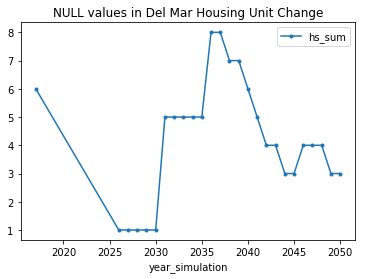

In [75]:
# Del Mar example
del_mar_before = sr14_geo_df.loc[4].sort_values(by='year_simulation')
# del_mar_before.head()
del_mar_before.plot(x='year_simulation',y='hs_sum',style='.-',title='NULL values in Del Mar Housing Unit Change')

In [76]:
# del_mar_before

In [77]:
idx = range(2017,2051)
sr14_geo_df.set_index(['geo','year_simulation'],append=True,inplace=True)
sr14_geo_df = sr14_geo_df.unstack(['jcid','geo'])
sr14_geo_df = sr14_geo_df.reindex(idx, fill_value=0)
sr14_geo_df.fillna(0,inplace=True)
sr14_geo_df = sr14_geo_df.stack(['jcid','geo'])
sr14_geo_df.reset_index(inplace=True)
sr14_geo_df.set_index('jcid',inplace=True)

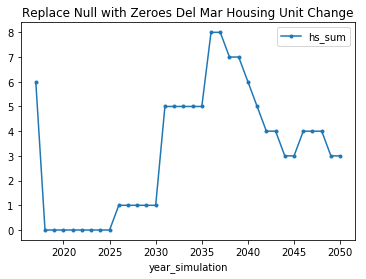

In [78]:
del_mar_after = sr14_geo_df.loc[4].sort_values(by='year_simulation')
del_mar_after.plot(x='year_simulation',y='hs_sum',style='.-',title='Replace Null with Zeroes Del Mar Housing Unit Change')

## Sum units from output of simulation over five year increments

In [79]:
bins = range(2015,2055,5)
names = [str(x) for x in range(2020,2055,5)]
sr14_geo_df['increment'] = pd.cut(sr14_geo_df.year_simulation, bins, labels=names)

In [80]:
sr14_increment = pd.DataFrame({'hs_increment': sr14_geo_df.
                                            groupby(["increment","jcid","geo"]).
                                 hs_sum.sum()}).reset_index()
# sr14_increment.set_index('jcid',inplace=True)

In [81]:
sr14_increment.increment = sr14_increment.increment.astype(int)

## Cumulative sum units added by increment

In [82]:
sr14_increment['hs_cumulative'] = sr14_increment.groupby(['geo'])['hs_increment'].apply(lambda x: x.cumsum())
sr14_increment.set_index('jcid',inplace=True)

## Join simulation output with existing dwelling units

In [83]:
sr14 = sr14_increment.join(du_sr14_geo_df)

In [84]:
sr14['hs'] = sr14['hs_cumulative'] + sr14['du_2017']

## Add increment 2016 with units added equal to zero for baseline du (for plotting)

In [85]:
start_year = sr14_geo_df.loc[sr14_geo_df.year_simulation==2017].copy()
len(start_year)
start_year['increment'] = 2015
start_year = start_year.join(du_sr14_geo_df)
start_year['hs'] = start_year['du']
start_year['year_simulation'] = 'baseline'
sr14 = pd.concat([sr14,start_year])

In [86]:
start_year['increment'] = 2017
start_year['hs'] = start_year['du_2017']
sr14 = pd.concat([sr14,start_year])

In [87]:
# sr14.loc[1420].sort_values(by='increment')

## SR13 aggregrate

####  mgra level housing to cpa and jurisdiction and group by increment and sum

In [88]:
sr13_df.head()

,mgra,hs,increment,cpa,site,jurisdiction_id,jcname,jcid
0,1,18,2012,1442,0,14,Uptown,1442
1,1,18,2015,1442,0,14,Uptown,1442
2,1,18,2020,1442,0,14,Uptown,1442
3,1,18,2025,1442,0,14,Uptown,1442
4,1,18,2030,1442,0,14,Uptown,1442


In [89]:
sr13_geo_df = pd.DataFrame({'hs_sum': sr13_df.groupby(['jcname','jcid','increment']).
                               hs.sum()}).reset_index()
sr13_geo_df.rename(columns = {'jcname':'geo'},inplace=True)
sr13_geo_df.sort_values(by='jcid',inplace=True)
#sr13_geo_df.head()

In [90]:
#sr13_geo_df.to_csv('test.csv')

In [91]:
print("\nNum of geographies (jurisdiction plus cpa) = {:,}\n".format(int(len(sr13_geo_df.loc[sr13_geo_df.increment==2015]))))


Num of geographies (jurisdiction plus cpa) = 103



##  sr13 pivot so each jurisdiction or cpa is column and rows are increments

In [92]:
sr13_geo_df_pivot = sr13_geo_df.pivot\
(index='increment', columns='geo', values='hs_sum').\
reset_index().rename_axis(None, axis=1)
sr13_geo_df_pivot.set_index('increment',inplace=True)

In [93]:
#sr13_geo_df_pivot

##  sr14 pivot so each jurisdiction or cpa is column and rows are increments

In [94]:
#sr14.head()

In [95]:
# sr14.to_csv('test2.csv')

In [96]:
sr14_geo_df_pivot = sr14.pivot\
(index='increment', columns='geo', values='hs').\
reset_index().rename_axis(None, axis=1)
sr14_geo_df_pivot.set_index('increment',inplace=True)
sr14_geo_df_pivot.fillna(0,inplace=True)

In [97]:
#sr14_geo_df_pivot

####  sr13 calculate total change by region and jurisdiction and cpa

In [98]:
total_diff = sr13_geo_df_pivot.loc[[2012,2050],:]
differences = total_diff.diff().loc[[2050]]
differences.rename(index={2050: 'total_change'},inplace=True)
totalchange = pd.DataFrame(differences.sum(axis=0))
totalchange.rename(columns={0: 'total_change'},inplace=True)
sr13_totalchange = pd.DataFrame(differences.sum(axis=0))
sr13_totalchange.rename(columns={0: 'total_change'},inplace=True)
print("\nTotal Units added sr13: {:,}".format(int(totalchange.total_change.sum())))


Total Units added sr13: 326,117


In [99]:
geolist = sr14_geo_df.geo.unique().tolist()

In [100]:
l = []
for jur in (geolist):
    s = str(jur)
    l.append(s)

In [101]:
#print '[%s]' % ', '.join(map(str, l))

# plot

### directory for plots

In [102]:
#print os.getcwd()

In [103]:
dirname = os.path.join(os.getcwd(),'plots/run'+str(run_id))#,datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
                       
                       # 'run_'+str(run_id) + '_city_cpa')
                         
try:
    os.stat(dirname)
except:
    os.mkdir(dirname)  

In [104]:
print(dirname)

C:\Users\aku\Documents\PycharmProjects\urbansim_lite\notebooks\plots/run295


In [105]:
geolist[0:1]

['Carlsbad']

In [106]:
jur

'County Islands'

In [107]:
#jur = 'Carlsbad'

In [108]:
sr13_sched_dev_totals.loc[ sr13_sched_dev_totals['geo']==jur]

,jcid,geo,sched_dev_sum
102,1999,County Islands,0.0


In [109]:
sr13_sched_dev_totals.loc[ sr13_sched_dev_totals['geo']==jur].iloc[0]['sched_dev_sum']

0.0

In [110]:
#sr13_sched_dev_totals['geo']

#### plot figures as png

In [111]:
scheddevlabel_sr13 = '(' + str(int( sr13_sched_dev_totals.loc[ sr13_sched_dev_totals['geo']==jur].iloc[0]['sched_dev_sum'])) + ' sched dev)'    


In [112]:
sr14_source1.head()

,source,geo,hs_sum
jcid,,,
1,1.0,Carlsbad,2470.0
2,1.0,Chula Vista,14838.0
3,1.0,Coronado,14.0
4,1.0,Del Mar,2.0
5,1.0,El Cajon,365.0


In [113]:
scheddevlabel = '(' + str(int(sr14_source1.loc[sr14_source1['geo']==jur].iloc[0]['hs_sum'])) + ' sched dev)'

In [114]:
sr13_geo_df_pivot.head()

,32nd Street Naval Station,Alpine,Balboa Park,Barona,Barrio Logan,Black Mountain Ranch,Bonsall,Carlsbad,Carmel Mountain Ranch,Carmel Valley,...,Tijuana River Valley,Torrey Highlands,Torrey Hills,Torrey Pines,University,Uptown,Valle De Oro,Valley Center,Via De La Valle,Vista
increment,,,,,,,,,,,,,,,,,,,,,
2012,0,6565,14,202,1232,2591,3905,45171,5072,13487,...,16,2259,2520,3077,26412,23100,15582,6664,224,30860
2015,0,6419,14,202,1232,4843,3949,46358,5072,13520,...,16,2260,2904,3156,27403,23160,15307,6785,224,31209
2020,0,7319,14,202,1397,5126,4329,48448,5072,13707,...,16,2688,2905,3082,28495,23593,15434,7830,230,31012
2025,0,7834,14,202,1394,5126,4553,49048,5072,13730,...,16,2689,2905,3098,28650,25880,15898,8059,230,32884
2030,0,8255,14,202,2214,5126,4893,49629,5072,13737,...,16,2690,2905,3132,28802,27674,16026,8343,230,34028


In [115]:

sr14_increments_int = sr14_geo_df_pivot[[jur]].reset_index().increment.tolist()
sr13_increments_int = sr13_geo_df_pivot[[jur]].reset_index().increment.tolist()

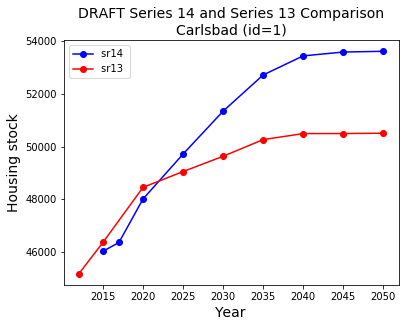

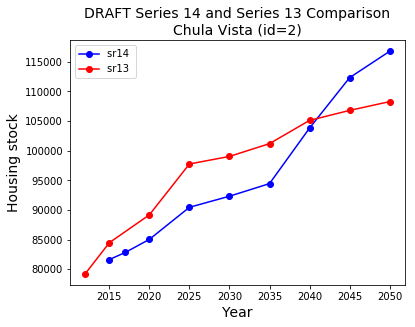

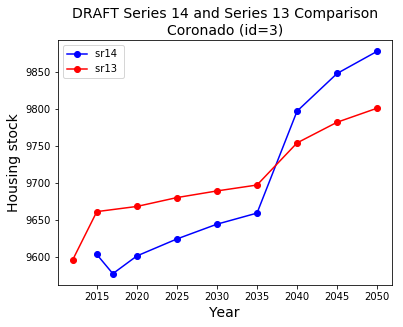

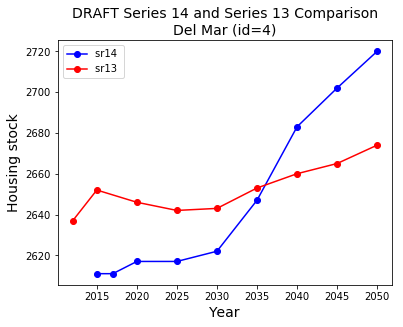

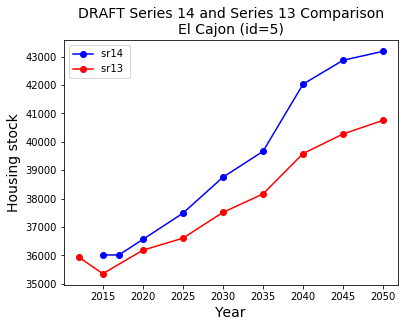

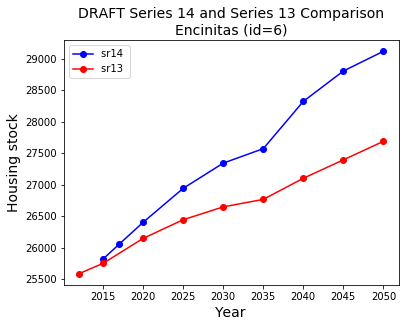

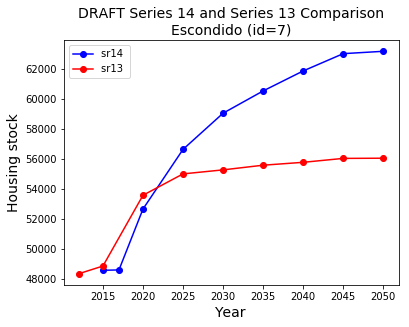

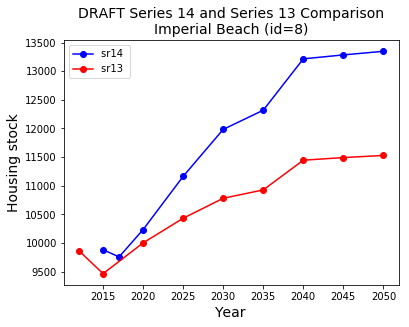

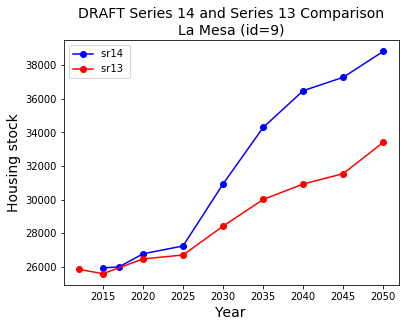

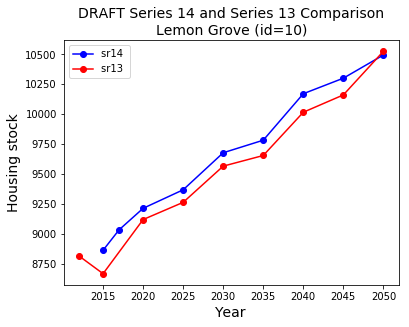

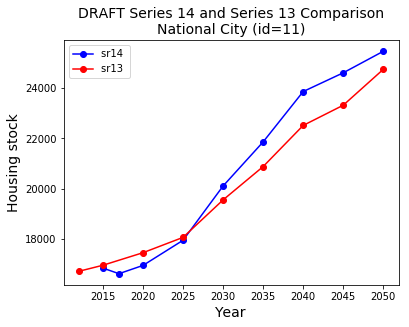

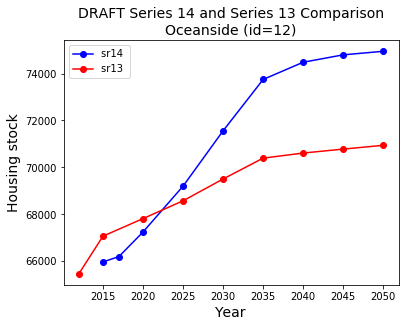

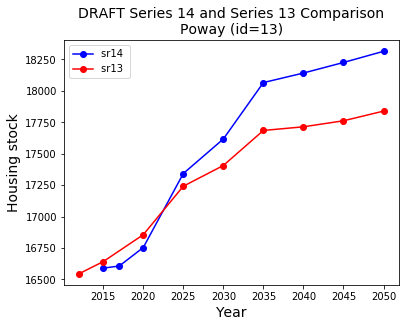

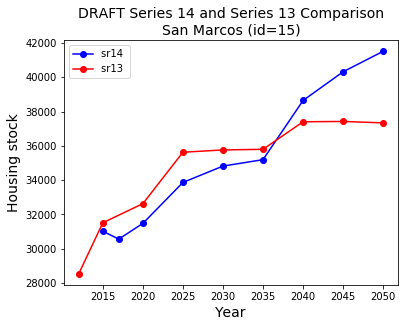

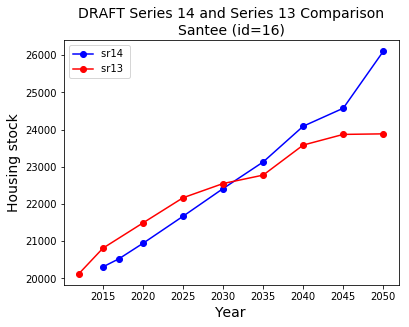

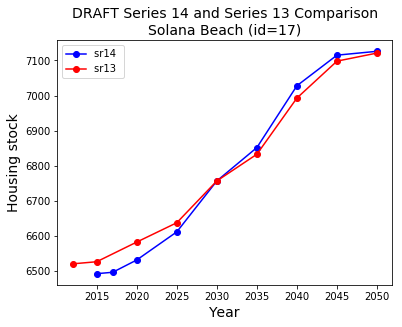

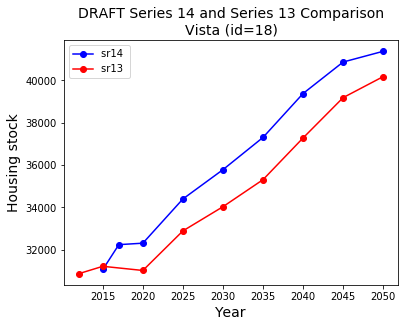

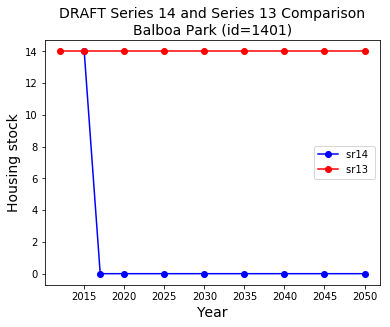

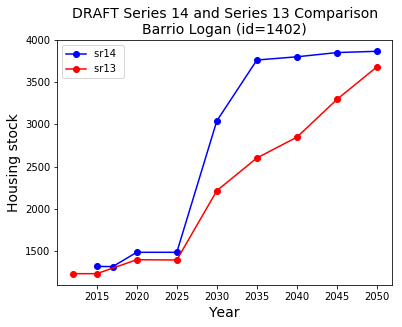

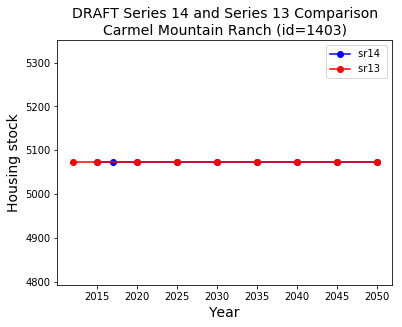

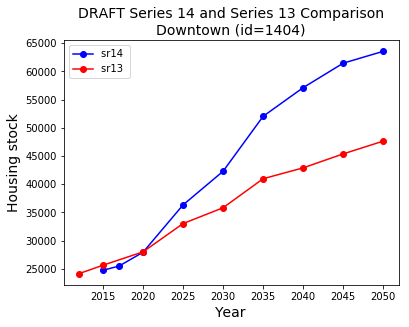

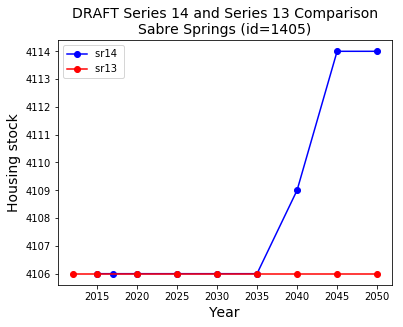

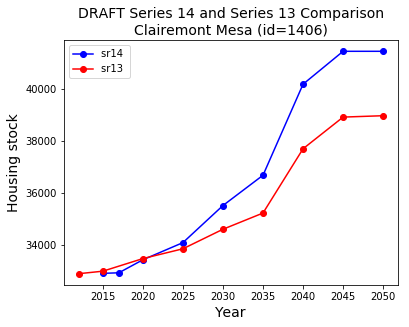

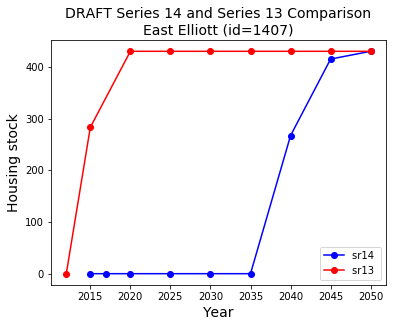

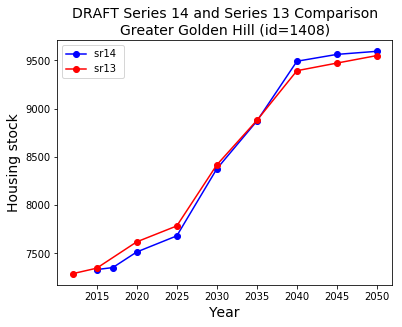

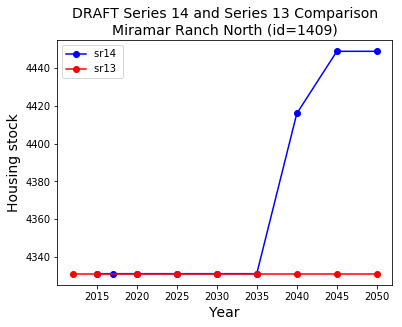

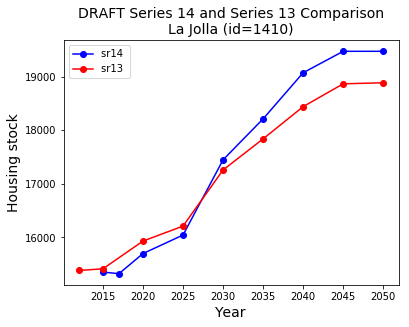

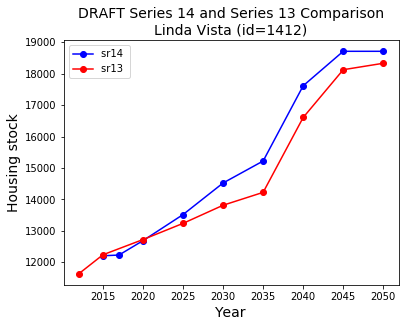

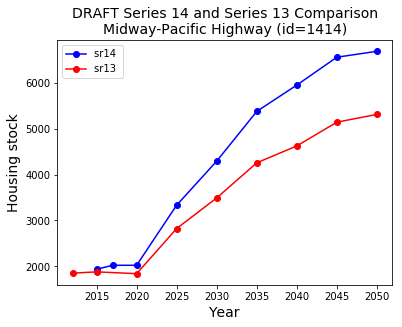

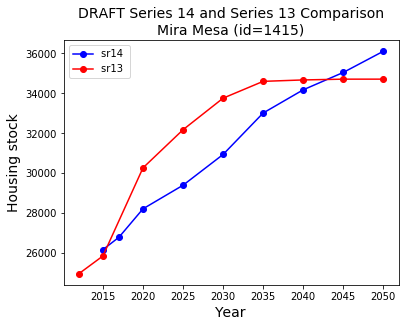

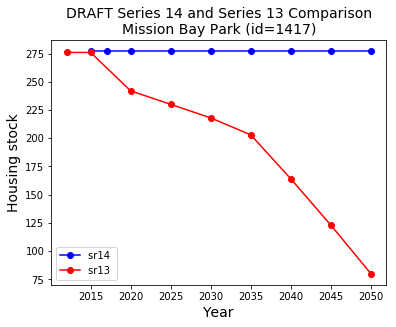

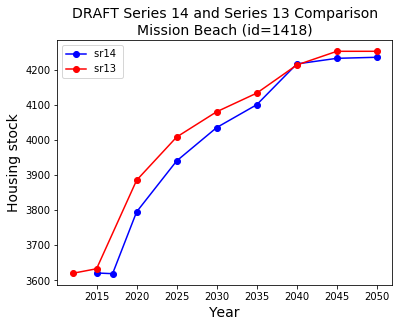

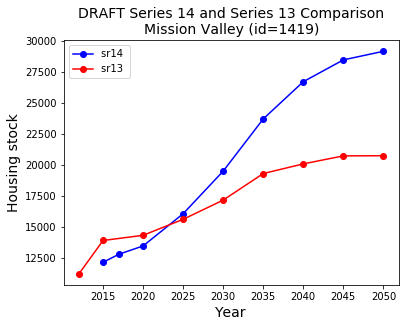

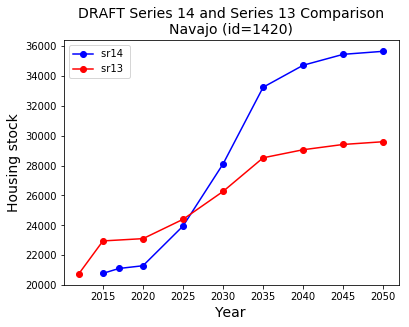

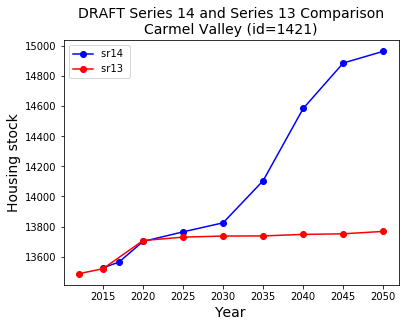

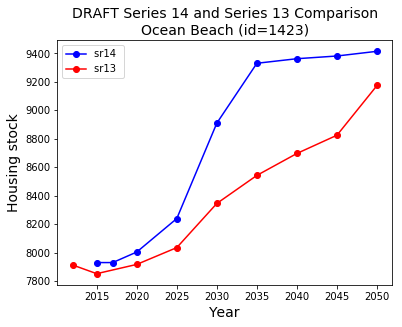

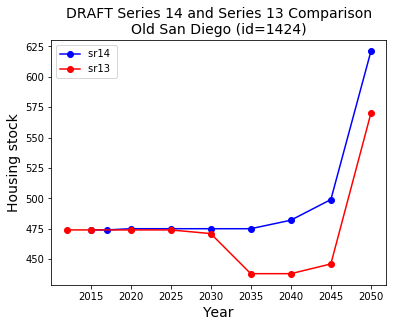

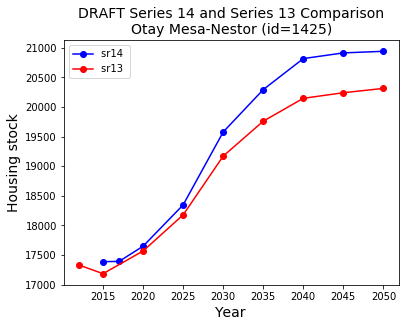

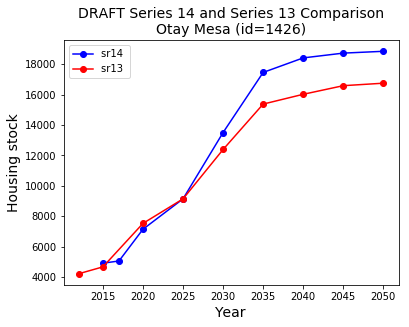

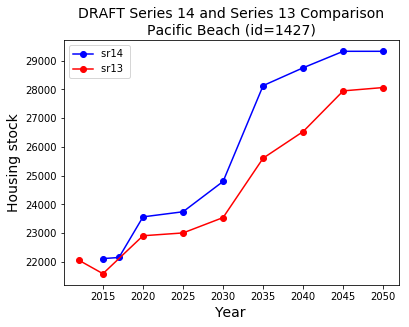

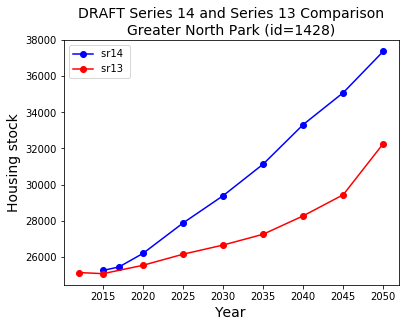

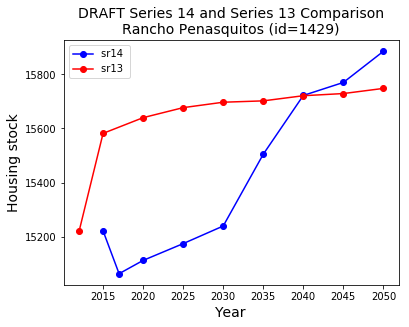

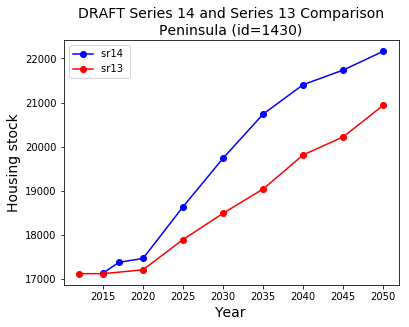

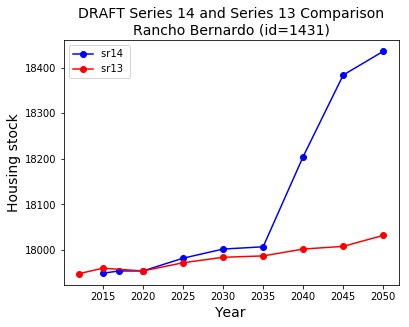

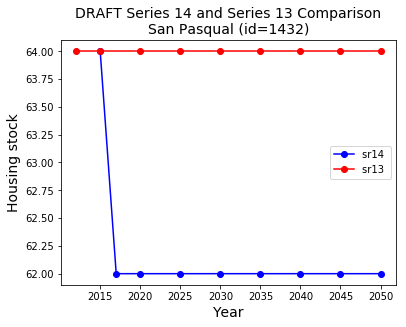

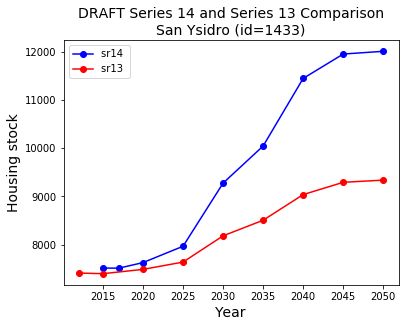

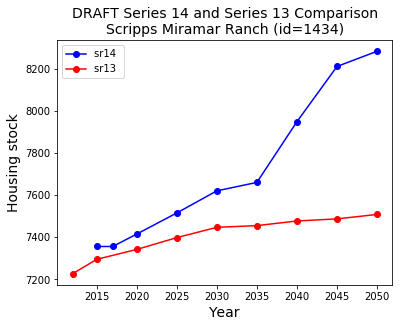

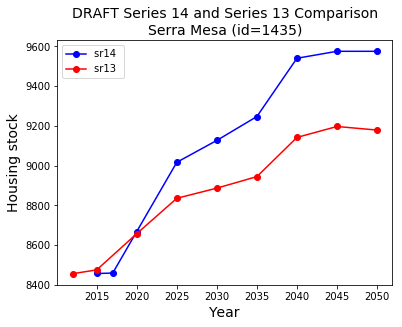

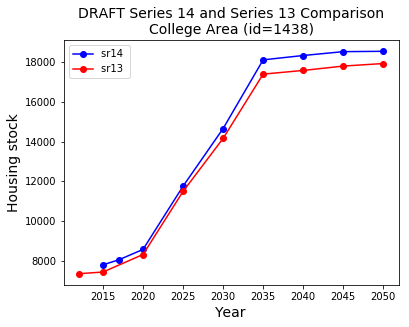

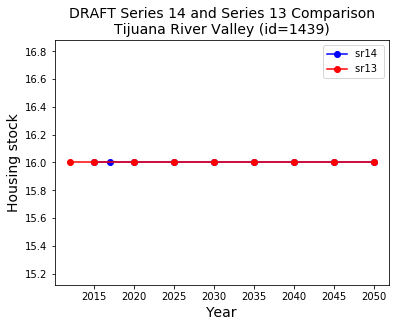

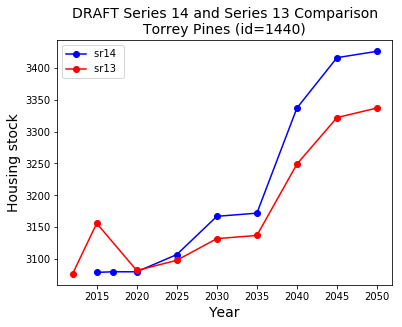

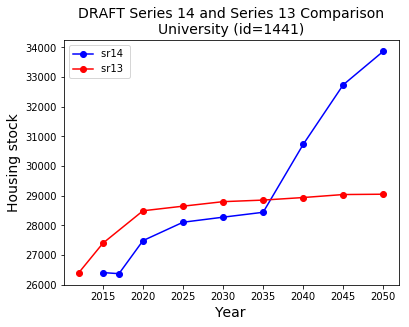

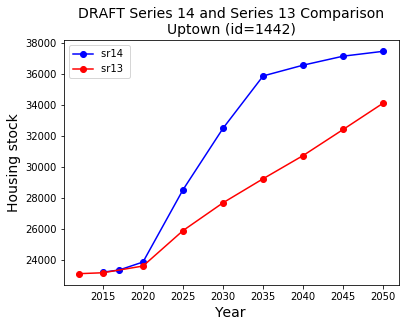

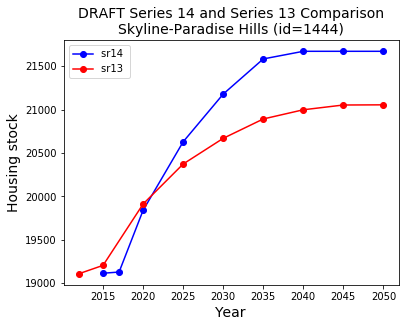

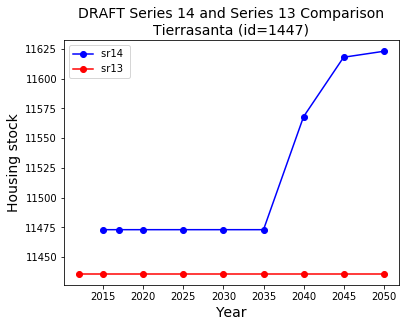

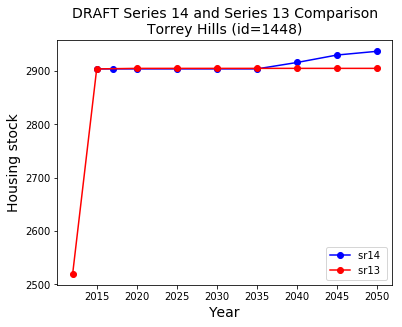

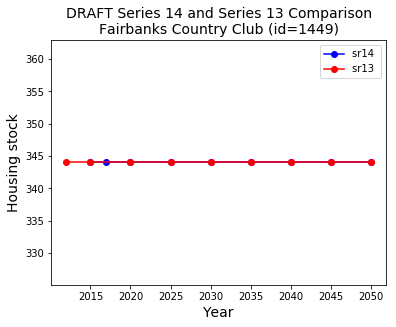

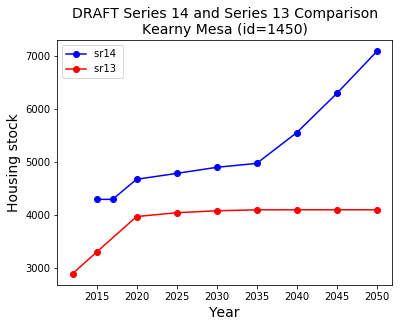

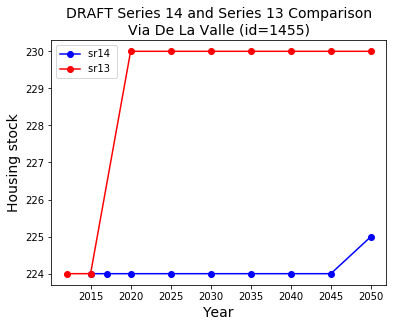

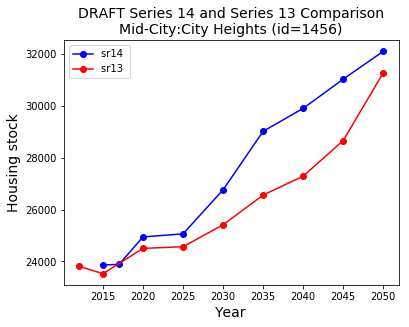

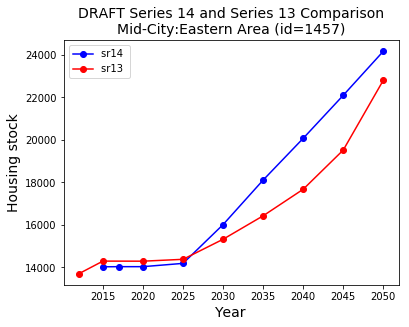

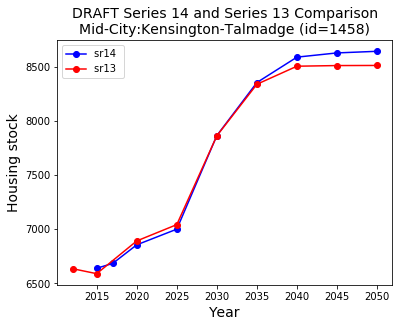

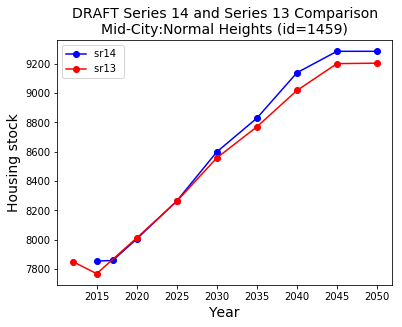

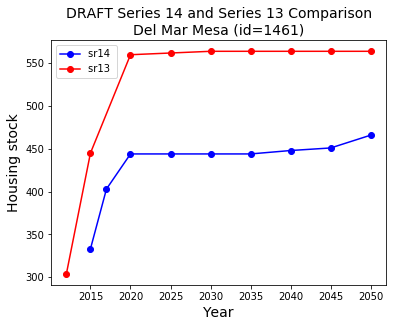

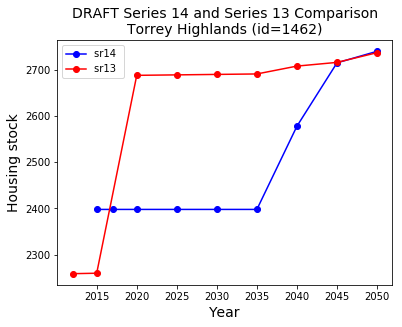

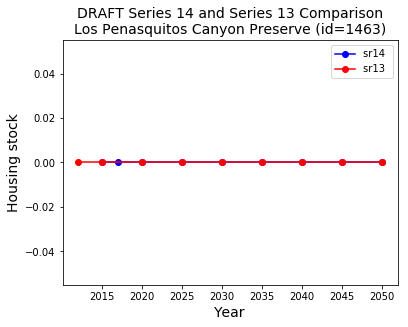

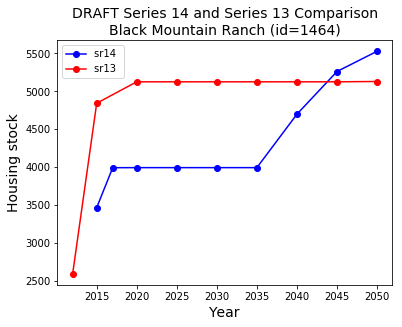

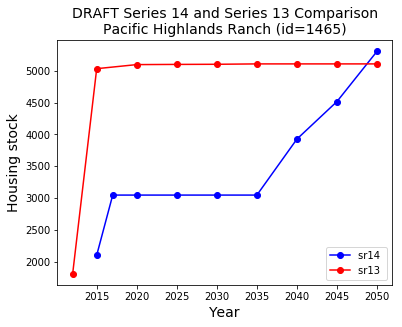

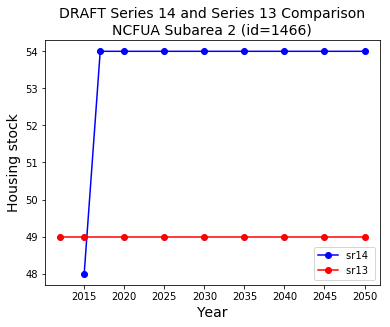

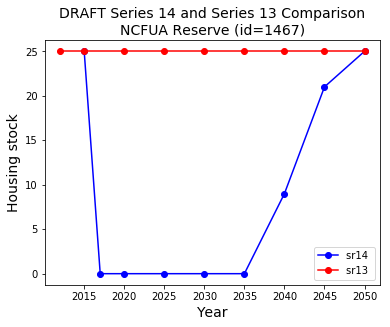

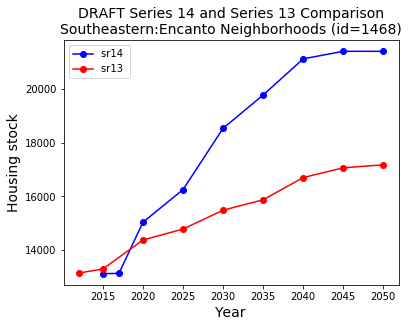

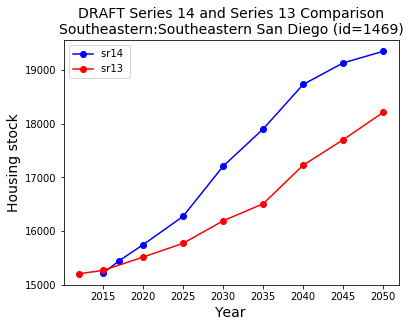

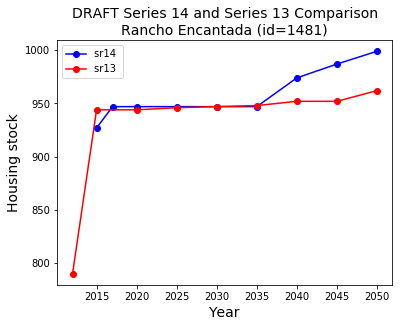

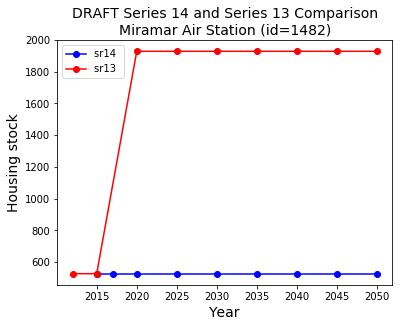

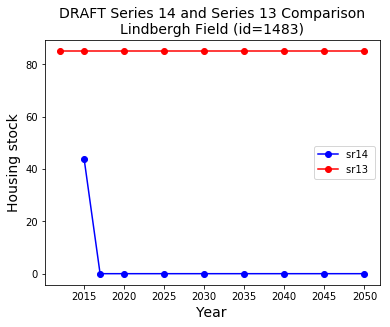

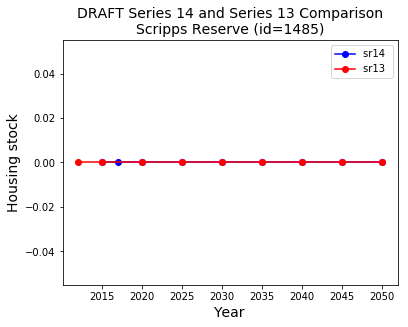

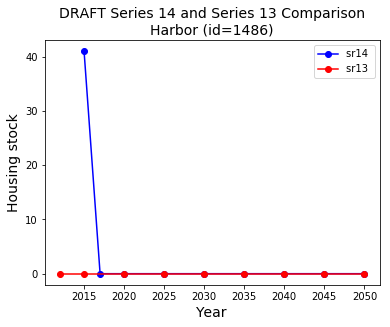

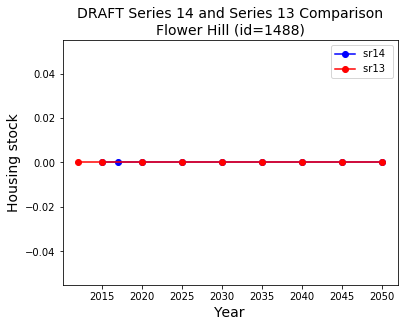

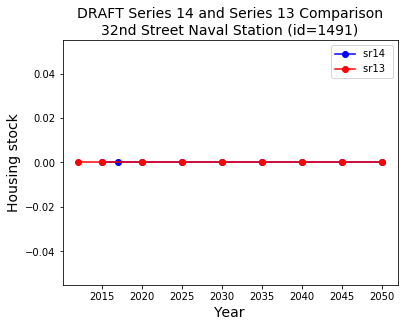

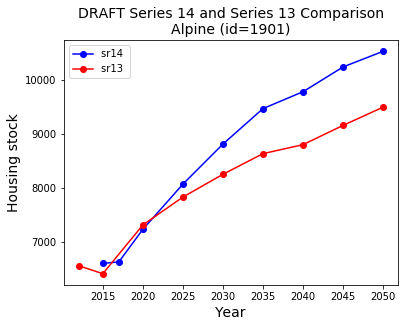

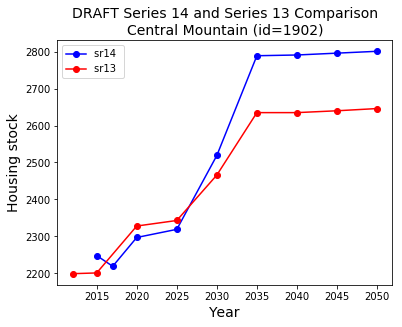

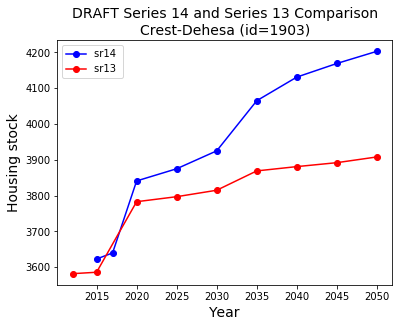

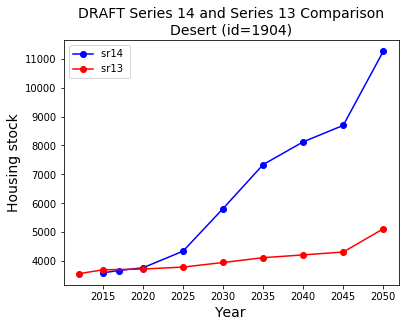

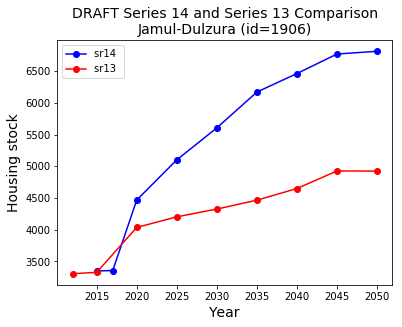

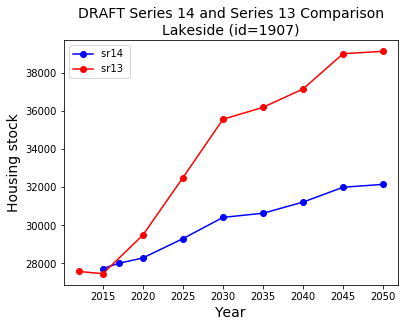

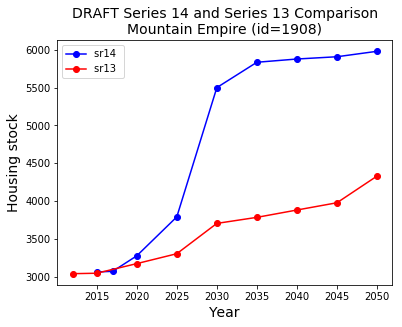

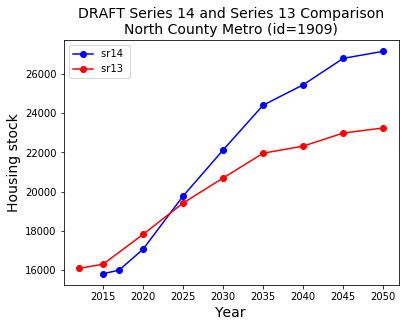

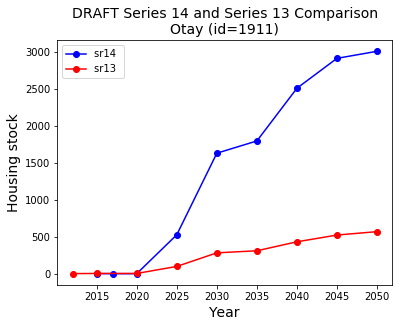

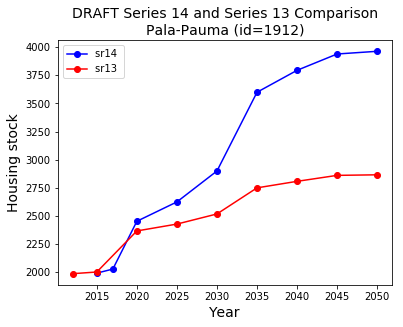

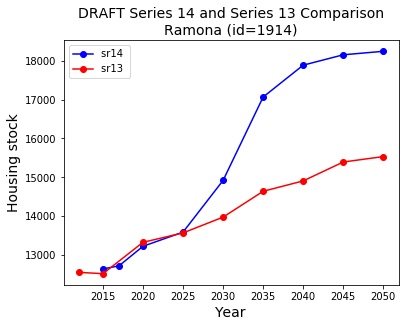

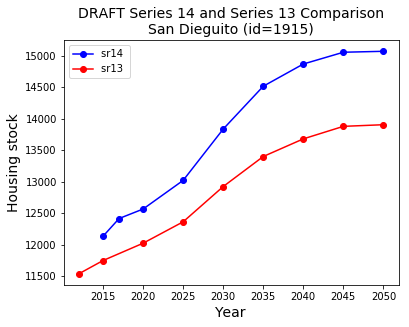

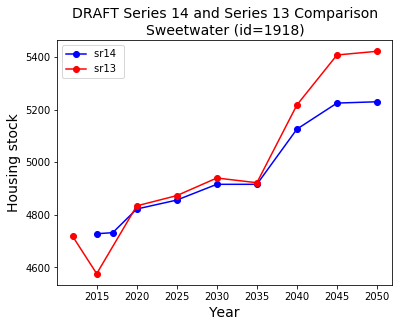

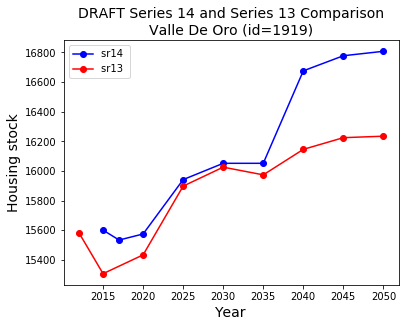

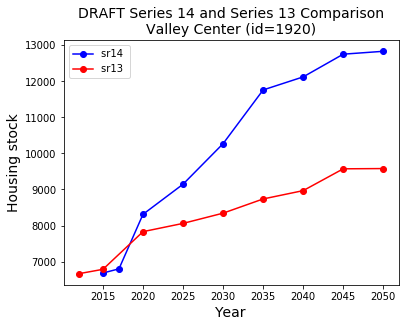

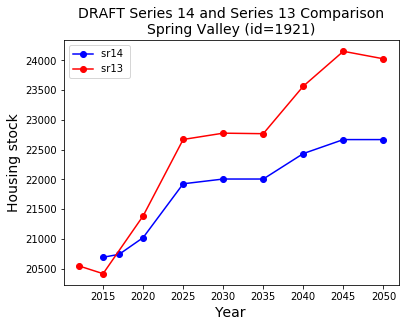

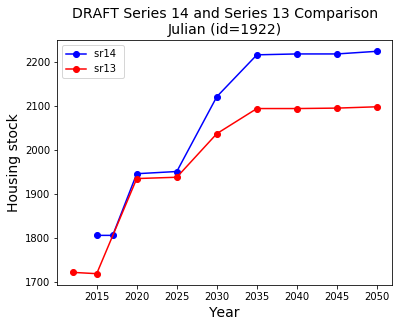

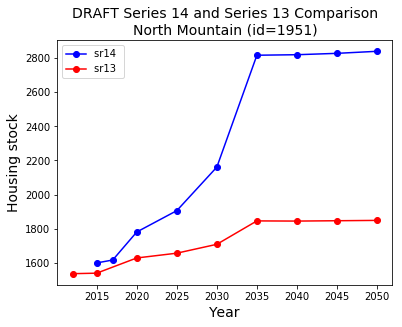

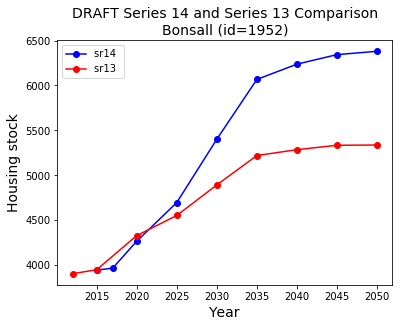

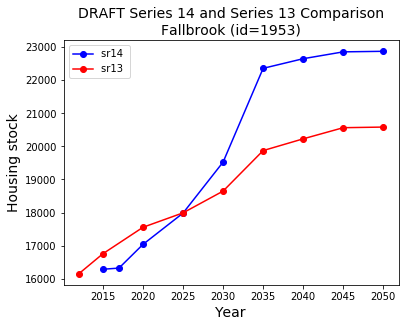

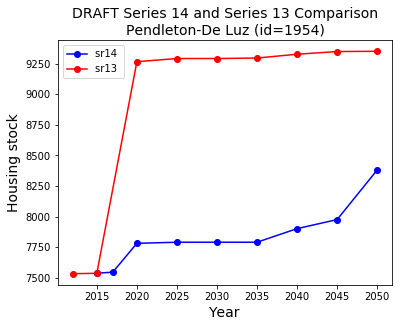

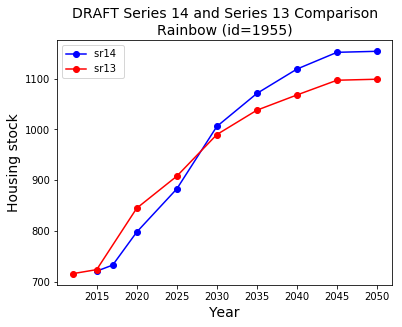

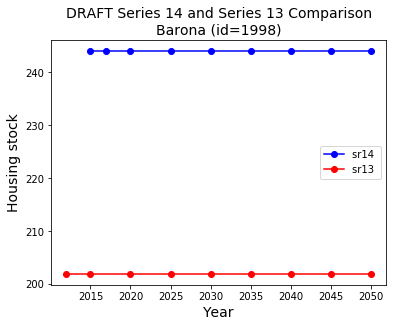

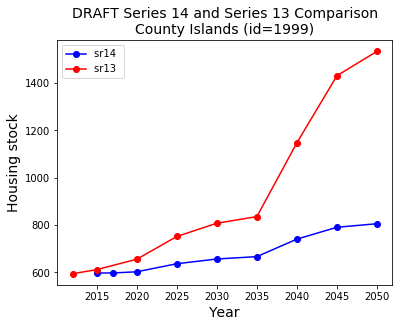

In [116]:
### COPY
for j, jur in enumerate(geolist):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        chg = int(sr14_increment.loc[(sr14_increment.increment==2050) & (sr14_increment.geo==jur)].hs_cumulative)
        plotlabelsr13 = 'sr13 '
        plotlabelsr14 = 'sr14 '
        scheddevlabel_sr13 = '(' + str(int( sr13_sched_dev_totals.loc[ sr13_sched_dev_totals['geo']==jur].iloc[0]['sched_dev_sum'])) + ' sched dev)'    
        scheddevlabel = '(' + str(int(sr14_source1.loc[sr14_source1['geo']==jur].iloc[0]['hs_sum'])) + ' sched dev)'
        sr14_increments_int = sr14_geo_df_pivot[[jur]].reset_index().increment.tolist()
        sr13_increments_int = sr13_geo_df_pivot[[jur]].reset_index().increment.tolist()
        
        
        sr14 = ax.plot(sr14_increments_int,
                       sr14_geo_df_pivot[[jur]].reset_index()[jur].tolist(),'b-o')
        sr13 = plt.plot(sr13_increments_int,
                        sr13_geo_df_pivot[[jur]].reset_index()[jur].tolist(),'r-o')
          
        city_cpa_id = str(sr14_geo_df.loc[sr14_geo_df['geo']==jur].index.values[0])  
       
        # legendtitle = jur + ' (' +  city_cpa_id + ')'

                
        # create blank rectangle
        extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        ax.legend([sr14[0],sr13[0]],\
                  (plotlabelsr14,plotlabelsr13))
        # extra2 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        # extra3 = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
        # ax.legend([extra, sr13[0],extra2,sr14[0],extra3], ("Total Chg", plotlabelsr13,scheddevlabel_sr13, plotlabelsr14,scheddevlabel))
        # plt.ylabel('Housing stock')
        # plt.xlabel('Year')
        # plt.title('Series 13 and DRAFT Series 14 Comparison\n' + jur + ' (id=' +  city_cpa_id + ')')
        ptitle = 'DRAFT Series 14 and Series 13 Comparison\n' + jur + ' (id=' +  str(city_cpa_id) + ')'
        ax.set_title(ptitle,fontsize= 14)
        ax.set_xlabel("Year",size=14)
        ax.set_ylabel("Housing stock",size=14)
        # ptitle = 'DRAFT Cumulative Housing Units Added By Capacity Type\n' + jur + ' (id=' +  str(city_cpa_id) + ')'
        jur_ = jur.replace(":", "_") # colon not allowed in windows filename
        plotname = dirname + '//' + 'city_cpa_' + city_cpa_id + '_' + jur_ + '.png'
        # plotname = dirname + '//' + str(run_id) + '_city_cpa_' + city_cpa_id + '_' + jur_ + '.png'

        fig = plt.gcf()
        fig.set_size_inches(6, 4.5)
        fig.savefig(plotname, bbox_inches='tight',dpi=200)
        plt.show()
        plt.close(fig)
        
        
        # ptitle = 'DRAFT Cumulative Housing Units Added By Capacity Type\n' + jur + ' (id=' +  str(city_cpa_id) + ')'
        # ax.set_ylabel("housing units added",size=14)
        # ax.set_title(ptitle,size=14)

In [117]:
sr13_sched_dev_totals.loc[ sr13_sched_dev_totals['geo']==jur]

,jcid,geo,sched_dev_sum
102,1999,County Islands,0.0


In [118]:
jur

'County Islands'

#  AS PDF instead of png

units_added_by_source.plot(style='.-',stacked=True,kind='bar',ax=axes.flat[2],\
                           figsize=(10,15),color=['red','purple','green','sandybrown'])

# QC data

In [119]:
bins = range(2015,2055,5)
names = [str(x) for x in range(2020,2055,5)]
units['increment'] = pd.cut(units.year_simulation, bins, labels=names)

In [120]:
units.head()

,jcid,parcel_id,hs_change,source,capacity_type,year_simulation,mgra,jcname,increment
0,1,329171.0,3.0,1.0,sch,2017,14090.0,Carlsbad,2020
1,1,684248.0,2.0,1.0,sch,2017,14090.0,Carlsbad,2020
2,1,5054670.0,11.0,1.0,sch,2017,14090.0,Carlsbad,2020
3,1,5312514.0,1.0,1.0,sch,2017,14224.0,Carlsbad,2020
4,1,5312511.0,1.0,1.0,sch,2017,14224.0,Carlsbad,2020


In [121]:

# "jcid","geo"
units_added_by_capacity_type_and_yr = pd.DataFrame({'units_by_type': units.
                                          groupby(["jcid","jcname","increment","capacity_type"])
                                          .hs_change.sum()}).reset_index()

In [122]:
geolist = units_added_by_capacity_type_and_yr.jcname.unique().tolist()

In [123]:
# geolist

In [124]:
units_added_by_capacity_type_and_yr.set_index(['jcid','jcname','increment','capacity_type'],inplace=True)
units_added_by_capacity_type_and_yr = units_added_by_capacity_type_and_yr.unstack(['jcid','jcname'])
units_added_by_capacity_type_and_yr.fillna(0,inplace=True)
units_added_by_capacity_type_and_yr = units_added_by_capacity_type_and_yr.stack(['jcid','jcname'])
units_added_by_capacity_type_and_yr.reset_index(inplace=True)

# Create tables

In [125]:
# for tablular data
assigned_parcel_sql = '''
SELECT  a.parcel_id,  a.du, a.type
   FROM [urbansim].[urbansim].[additional_capacity] a
  WHERE version_id = %s'''
assigned_parcel_sql = assigned_parcel_sql % versions['additional_capacity_version']
assigned_df = pd.read_sql(assigned_parcel_sql, mssql_engine)
assigned_df.replace('cc', 'sgoa',inplace=True)
assigned_df.replace('mc', 'sgoa',inplace=True)
assigned_df.replace('tc', 'sgoa',inplace=True)
assigned_df.replace('tco', 'sgoa',inplace=True)
assigned_df.replace('uc', 'sgoa',inplace=True)

# assigned_df.head()

In [126]:
# for tablular data
assignedcpa = pd.merge(assigned_df,geo,left_on='parcel_id',right_on='parcel_id',how='left')
assignedcpa.loc[assignedcpa.jurisdiction_id == 19,'jcid'] = assignedcpa['cpa_id']
assignedcpa.loc[assignedcpa.jurisdiction_id == 14,'jcid'] = assignedcpa['cpa_id']
assignedcpa['jcid'].fillna(assignedcpa['jurisdiction_id'],inplace=True)
#assignedcpa.loc[assignedcpa.mgra_id==19415,'jcid'] = 1909
#assignedcpa.loc[assignedcpa.mgra_id==18831,'jcid'] = 1909
#assignedcpa.loc[assignedcpa.mgra_id==11514.0,'jcid'] = 13
#assignedcpa.loc[assignedcpa.mgra_id==7521.0,'jcid'] = 3
#assignedcpa.loc[assignedcpa.mgra_13==7259,'jcid'] = 1439 

In [127]:
# for tablular data
sched_dev_parcel_sql = '''
SELECT s.parcel_id,capacity_3
FROM [urbansim].[urbansim].[scheduled_development_parcel] s'''
sched_dev_df = pd.read_sql(sched_dev_parcel_sql, mssql_engine)
sched_dev_capacity = int(sched_dev_df.capacity_3.sum())
print("\nScheduled development capacity from urbansim.scheduled_development_parcel : {:,}".\
      format(sched_dev_capacity))


Scheduled development capacity from urbansim.scheduled_development_parcel : 78,976


In [128]:
# for tablular data
sunits = pd.merge(sched_dev_df,geo,left_on='parcel_id',right_on='parcel_id',how='left')
sunits.loc[sunits.jurisdiction_id == 19,'jcid'] = sunits['cpa_id']
sunits.loc[sunits.jurisdiction_id == 14,'jcid'] = sunits['cpa_id']
sunits['jcid'].fillna(sunits['jurisdiction_id'],inplace=True)

In [129]:
# for tablular data
parcel_capacity_sql = '''
    SELECT [parcel_id],[site_id],
           [du_2015],[du_2017],[capacity_1],[capacity_2]
      FROM [urbansim].[urbansim].[parcel]'''
capacity_df = pd.read_sql(parcel_capacity_sql,mssql_engine)
urbansim_parcel_capacity = int(capacity_df.loc[capacity_df.site_id.isnull()].capacity_2.sum())
print("\nCapacity from urbansim.parcel where site id is null: {:,}".format(urbansim_parcel_capacity))
# 291,989


Capacity from urbansim.parcel where site id is null: 291,712


In [130]:
capacity_df.head()

,parcel_id,site_id,du_2015,du_2017,capacity_1,capacity_2
0,2,NaN,1,1,0,0
1,3,NaN,1,1,0,0
2,4,NaN,0,0,1,1
3,5,NaN,1,1,0,0
4,6,NaN,1,1,0,0


In [131]:
# for tablular data
urb_parcel_units = pd.merge(capacity_df,geo,left_on='parcel_id',right_on='parcel_id',how='left')
urb_parcel_units.loc[urb_parcel_units.jurisdiction_id == 19,'jcid'] = urb_parcel_units['cpa_id']
urb_parcel_units.loc[urb_parcel_units.jurisdiction_id == 14,'jcid'] = urb_parcel_units['cpa_id']
urb_parcel_units['jcid'].fillna(urb_parcel_units['jurisdiction_id'],inplace=True)
print(len(urb_parcel_units))
print(len(capacity_df))

813293
813293


# use this for bar plots and tabular data

In [132]:
for j, jur in enumerate(geolist):
    c = units_added_by_capacity_type_and_yr.loc[units_added_by_capacity_type_and_yr.jcname==jur]
    type_pivot = c.pivot(index='increment', columns='capacity_type', values='units_by_type').\
    reset_index().rename_axis(None, axis=1)
    
    type_pivot.set_index('increment',inplace=True)
    type_pivot.fillna(0,inplace=True)
    type_pivot = type_pivot[['sch', 'jur', 'adu', 'sgoa']]
    type_pivot['sch'] = type_pivot['sch'].cumsum()
    type_pivot['jur'] = type_pivot['jur'].cumsum()
    type_pivot['adu'] = type_pivot['adu'].cumsum()
    type_pivot['sgoa'] = type_pivot['sgoa'].cumsum()
    
    city_cpa_id = c.iloc[0]['jcid']
    
    ax = type_pivot.plot.bar(stacked=True,rot=0)
    
    ptitle = 'DRAFT Cumulative Housing Units Added By Capacity Type\n' + jur + ' (id=' +  str(city_cpa_id) + ')'
    ax.set_ylabel("Housing units added",size=14)
    ax.set_title(ptitle,size=14)
    ax.set_xlabel("Year",size=14)
    
    fig = plt.gcf()
    fig.set_size_inches(6, 4.5)
    jur_ = jur.replace(":", "_") # colon not allowed in windows filename
    plotname = dirname + '//' + 'city_cpa_' + str(city_cpa_id) + '_' + jur_ + 'bar.png'
    fig.savefig(plotname, bbox_inches='tight',dpi=200)
    #plt.show()
    plt.close(fig)

In [133]:
# This is the right table in the pp
for j, jur in enumerate(geolist):
    jur_ = jur.replace(":", "_")  # colon not allowed in windows filename
    c = units_added_by_capacity_type_and_yr.loc[units_added_by_capacity_type_and_yr.jcname==jur]
    type_pivot = c.pivot(index='increment', columns='capacity_type', values='units_by_type').\
        reset_index().rename_axis(None, axis=1)
    city_cpa_id = c.iloc[0]['jcid']
    hs_1 = units.loc[units.jcid==city_cpa_id]
    units_added = int(hs_1.hs_change.sum())
    
    type_pivot.set_index('increment',inplace=True)
    type_pivot.fillna(0,inplace=True)
    type_pivot = type_pivot[['sch', 'jur', 'adu', 'sgoa']]
    sum_sgoa = int(type_pivot.sgoa.sum())
    sum_adu = int(type_pivot.adu.sum())
    sum_jur = int(type_pivot.jur.sum())
    sum_sch = int(type_pivot.sch.sum())
    
    type_pivot.sgoa.fillna(0,inplace=True)
    type_pivot.adu.fillna(0,inplace=True)
    type_pivot.jur.fillna(0,inplace=True)
    type_pivot.sch.fillna(0,inplace=True)
    if units_added == 0:
        percent_total = str(0) + '%'
        percent_sch = str(0) + '%'
        percent_jur = str(0) + '%'
        percent_provided = str(0) + '%'
        percent_adu = str(0) + '%'
        percent_sgoa = str(0) + '%'
        percent_additional = str(0) + '%'
    else:
        percent_total = str(round(units_added/units_added * 100)) + '%'
        percent_sch = str(round(sum_sch/units_added * 100)) + '%'
        percent_jur = str(round(sum_jur/units_added * 100)) + '%'
        percent_provided = str(round((sum_sch+sum_jur)/units_added * 100)) + '%'
        percent_adu = str(round(sum_adu/units_added * 100)) + '%'
        percent_sgoa = str(round(sum_sgoa/units_added * 100)) + '%'
        percent_additional = str(round((sum_adu+sum_sgoa)/units_added * 100)) + '%'
        
    assigned_df_1 = assignedcpa.loc[assignedcpa.jcid==city_cpa_id]
    assigned_capacity_1 = int(assigned_df_1.du.sum())
    assigned_capacity_adu = int(assigned_df_1.loc[assigned_df.type=='adu'].du.sum())
    assigned_capacity_sgoa = int(assigned_df_1.loc[assigned_df.type=='sgoa'].du.sum())
    sched_dev_df_1 = sunits.loc[sunits.jcid==city_cpa_id]
    sched_dev_capacity_1 = int(sched_dev_df_1.capacity_3.sum())
    capacity_df_1 = urb_parcel_units.loc[urb_parcel_units.jcid==city_cpa_id]
    urbansim_parcel_capacity_1 = int(capacity_df_1.loc[capacity_df_1.site_id.isnull()].capacity_2.sum())
    total_capacity_1 = assigned_capacity_1 + sched_dev_capacity_1 + urbansim_parcel_capacity_1
    remaining_total = total_capacity_1 - units_added
    remaining_sch = sched_dev_capacity_1 - sum_sch
    remaining_jur = urbansim_parcel_capacity_1 - sum_jur
    remaining_adu = assigned_capacity_adu - sum_adu
    remaining_sgoa = assigned_capacity_sgoa - sum_sgoa
    
    share_count = pd.DataFrame({'Total Units Added': [units_added, (sum_sch + sum_jur), sum_sch, sum_jur, \
                                                      (sum_adu + sum_sgoa), sum_adu, sum_sgoa], \
                                'Percentage Units Added': [percent_total, percent_provided, percent_sch, percent_jur, \
                                                           percent_additional, percent_adu, percent_sgoa], \
                                'Total Capacity': [total_capacity_1, (sched_dev_capacity_1 + urbansim_parcel_capacity_1), \
                                                   sched_dev_capacity_1, urbansim_parcel_capacity_1, \
                                                   (assigned_capacity_adu + assigned_capacity_sgoa), assigned_capacity_adu, \
                                                   assigned_capacity_sgoa], \
                                'Remaining Capacity': [remaining_total, (remaining_sch + remaining_jur), remaining_sch, \
                                                       remaining_jur, (remaining_adu + remaining_sgoa), remaining_adu, \
                                                       remaining_sgoa]}, \
                               index=['Total Capacity', '+  Jurisdiction Provided Capacity', '     -  Scheduled Development', \
                                      '     -  Not Scheduled Development', '+  Additional Capacity', \
                                      '     -  Additional Dwelling Units', '     -  SGOA Additional Capacity'])
        
    cols = ['Total Units Added','Percentage Units Added','Total Capacity','Remaining Capacity']
    share_count = share_count[cols] 
    share_count.index.name = 'Housing Units by Capacity Type'
    fig, ax = plt.subplots(figsize=(12, 4)) # set size frame
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis
    ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
    tabla = table(ax, share_count, loc='upper right', colWidths=[0.18, 0.25, 0.16, 0.20])  
    # colWidths=[0.22]*len(share_count.columns)
    tabla.auto_set_font_size(False) # Activate set fontsize manually
    tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
    #tabla.scale(1.2, 1.2) # change size table
    tabla.scale(1, 4)
    
    plotname = dirname + '//' + 'city_cpa_' + str(city_cpa_id) + '_' + jur_ + 'percent_capacity_type_table.png'
    
    plt.savefig(plotname, bbox_inches="tight",transparent=True)
    plt.close(fig)

In [134]:
# This is the left table in the pp
for j, jur in enumerate(geolist):
    jur_ = jur.replace(":", "_")  # colon not allowed in windows filename
    c = units_added_by_capacity_type_and_yr.loc[units_added_by_capacity_type_and_yr.jcname==jur]
    type_pivot = c.pivot(index='increment', columns='capacity_type', values='units_by_type').\
        reset_index().rename_axis(None, axis=1)
    city_cpa_id = c.iloc[0]['jcid']
    
    type_pivot.set_index('increment',inplace=True)
    type_pivot.fillna(0,inplace=True)
    type_pivot = type_pivot[['sch', 'jur', 'adu', 'sgoa']]
    sum_sgoa = int(type_pivot.sgoa.sum())
    sum_adu = int(type_pivot.adu.sum())
    sum_jur = int(type_pivot.jur.sum())
    sum_sch = int(type_pivot.sch.sum())
    
    # sr14_geo_df_pivot[[jur]]
    # sr13_geo_df_pivot[[jur]]
    hs_base_sr13 = int(sr13_geo_df_pivot[[jur]].loc[2012].values[0])
    hs_base_sr14 = int(sr14_geo_df_pivot[[jur]].loc[2017].values[0])
    hs_final_sr13 = int(sr13_geo_df_pivot[[jur]].loc[2050].values[0])
    hs_final_sr14 = int(sr14_geo_df_pivot[[jur]].loc[2050].values[0])
    scheddev_sr13 = int(sr13_sched_dev_totals.loc[ sr13_sched_dev_totals['geo']==jur].iloc[0]['sched_dev_sum'])
    scheddev_sr14 = int(sr14_source1.loc[sr14_source1['geo']==jur].iloc[0]['hs_sum'])
    total_chg_sr13 = int(sr13_totalchange.loc[jur][0])
    total_chg_sr14 = int(sr14_increment.loc[(sr14_increment.increment==2050) & (sr14_increment.geo==jur)].hs_cumulative)
    NOT_scheddev_sr13 = total_chg_sr13 - scheddev_sr13
    NOT_scheddev_sr14 = total_chg_sr14 - scheddev_sr14

    if hs_base_sr13 == 0:
        percent_sr13 = str(0) + '%'       
    else:
        percent_sr13 = str(round(total_chg_sr13/hs_base_sr13 * 100)) + '%'
    if hs_base_sr14 == 0:
        percent_sr14 = str(0) + '%'         
    else:
        percent_sr14 = str(round(total_chg_sr14/hs_base_sr14 * 100)) + '%'
    if total_chg_sr13 == 0:
        percent_chg_sr13_14 = 0
    else:
        percent_chg_sr13_14 = str(round(total_chg_sr14/total_chg_sr13 * 100)) + '%'
    
    if total_chg_sr14 != (sum_sch + sum_jur + sum_adu + sum_sgoa):
        print("Numbers don't match in "+str(city_cpa_id)+"!")
        print("total_chg_sr14: "+str(total_chg_sr14))
        print("scheddev_sr14 + NOT_scheddev_sr14: "+str(scheddev_sr14 + NOT_scheddev_sr14))
        print("sum_sch + sum_jur + sum_adu + sum_sgoa: "+str(sum_sch + sum_jur + sum_adu + sum_sgoa))
    
    sr13_sr14_hs = pd.DataFrame({'sr13': [hs_base_sr13, hs_final_sr13, total_chg_sr13, (scheddev_sr13 + NOT_scheddev_sr13), \
                                          0, percent_sr13], \
                                 'sr14': [hs_base_sr14, hs_final_sr14, total_chg_sr14, (sum_sch + sum_jur), \
                                          (sum_adu + sum_sgoa), percent_sr14], \
                                 'chg': [(hs_base_sr14 - hs_base_sr13), (hs_final_sr14 - hs_final_sr13), \
                                         (total_chg_sr14 - total_chg_sr13), \
                                         ((sum_sch + sum_jur) - (scheddev_sr13 + NOT_scheddev_sr13)), \
                                         ((sum_adu + sum_sgoa) - 0), percent_chg_sr13_14]},
                     index=['Base Year Housing Units (2012/2017)', 'Total Housing Units (2050)', 'Total Change', \
                            '+  Jurisdiction Provided Capacity','+  Additional Capacity', 'Total Percent Change'])
    sr13_sr14_hs = sr13_sr14_hs[['sr13', 'sr14', 'chg']]
    #print(sr13_sr14_hs)
    # sr13_sr14_hs
    fig, ax = plt.subplots(figsize=(8, 4)) # set size frame
    ax.xaxis.set_visible(False)  # hide the x axis
    ax.yaxis.set_visible(False)  # hide the y axis
    ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
    tabla = table(ax, sr13_sr14_hs, loc='upper right', colWidths=[0.16, 0.16, 0.16])
    # colWidths=[0.22]*len(share_count.columns)
    tabla.auto_set_font_size(False) # Activate set fontsize manually
    tabla.set_fontsize(12) # if ++fontsize is necessary ++colWidths
    #tabla.scale(1.2, 1.2) # change size table
    tabla.scale(1, 4)
    plotname = dirname + '//' + 'city_cpa_' + str(city_cpa_id) + '_' + jur_ + 'forecast_comparison.png'
    #plotname = dirname + '//' + str(run_id) + '_city_cpa_' + str(city_cpa_id) + '_' + jur_ + 'percent_capacity_type_table.png'
    plt.savefig(plotname, bbox_inches="tight",transparent=True)
    plt.close(fig)